In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc
import time
from torch.optim.lr_scheduler import StepLR
import os

# Step 1: Defining the VGG-13 Architecture
class VGG13(nn.Module):
    def __init__(self, num_classes=47):  
        super(VGG13, self).__init__()
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(1, 64, kernel_size=3, padding=1),  
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Block 4
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        # Fully connected layers with dropout
        self.classifier = nn.Sequential(
            nn.Linear(512 * 1 * 1, 4096),  # Did adjustment for EMNIST input size
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, num_classes)
        )
        
        # Initializing the weights
        self._initialize_weights()
    
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

In [29]:
# Step 2: Data Loading and Preprocessing
def load_data():
    data_dir = './data/EMNIST'
    download = not os.path.exists(data_dir)  

    transform = transforms.Compose([
        transforms.Resize((28, 28)),  
        transforms.ToTensor(),
        transforms.Normalize((0.1751,), (0.3332,)) 
    ])
    
    train_dataset = datasets.EMNIST(
        root='./data', split='balanced', train=True, download=download, transform=transform
    )
    test_dataset = datasets.EMNIST(
        root='./data', split='balanced', train=False, download=download, transform=transform
    )
    
    # Splitting the training data into train and validation data
    train_size = int(0.8 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(
        train_dataset, [train_size, val_size]
    )
    
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)
    
    return train_loader, val_loader, test_loader

In [30]:
# Step 3: Training Function with Early Stopping
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    start_time = time.time()
    
    best_val_acc = 0.0
    patience = 5  
    wait = 0
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100. * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        
        val_loss = val_loss / len(val_loader)
        val_acc = 100. * correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        
        scheduler.step()
        
        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        
        # Early stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print(f'Early stopping at epoch {epoch+1}')
                break
    
    training_time = time.time() - start_time
    print(f'Training completed in {training_time:.2f} seconds')
    
    return train_losses, train_accuracies, val_losses, val_accuracies, training_time

In [31]:
# Step 4: Evaluation Functions
def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    test_loss = test_loss / len(test_loader)
    test_acc = 100. * correct / total
    
    # For calculating precision, recall, and F1 score
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='weighted'
    )
    
    return test_loss, test_acc, precision, recall, f1, all_preds, all_labels

Using device: cpu
Epoch [1/100]
Train Loss: 2.0359, Train Acc: 43.82%
Val Loss: 0.5424, Val Acc: 81.61%
Epoch [2/100]
Train Loss: 0.4755, Train Acc: 83.33%
Val Loss: 0.4167, Val Acc: 85.20%
Epoch [3/100]
Train Loss: 0.3783, Train Acc: 86.36%
Val Loss: 0.3627, Val Acc: 86.99%
Epoch [4/100]
Train Loss: 0.3275, Train Acc: 87.93%
Val Loss: 0.3598, Val Acc: 87.47%
Epoch [5/100]
Train Loss: 0.2999, Train Acc: 88.77%
Val Loss: 0.3560, Val Acc: 87.01%
Epoch [6/100]
Train Loss: 0.2745, Train Acc: 89.53%
Val Loss: 0.3380, Val Acc: 87.97%
Epoch [7/100]
Train Loss: 0.2576, Train Acc: 90.03%
Val Loss: 0.3472, Val Acc: 87.72%
Epoch [8/100]
Train Loss: 0.2416, Train Acc: 90.57%
Val Loss: 0.3479, Val Acc: 87.82%
Epoch [9/100]
Train Loss: 0.2291, Train Acc: 90.99%
Val Loss: 0.3470, Val Acc: 88.15%
Epoch [10/100]
Train Loss: 0.2156, Train Acc: 91.38%
Val Loss: 0.3558, Val Acc: 87.76%
Epoch [11/100]
Train Loss: 0.2047, Train Acc: 91.63%
Val Loss: 0.3442, Val Acc: 88.25%
Epoch [12/100]
Train Loss: 0.1953,

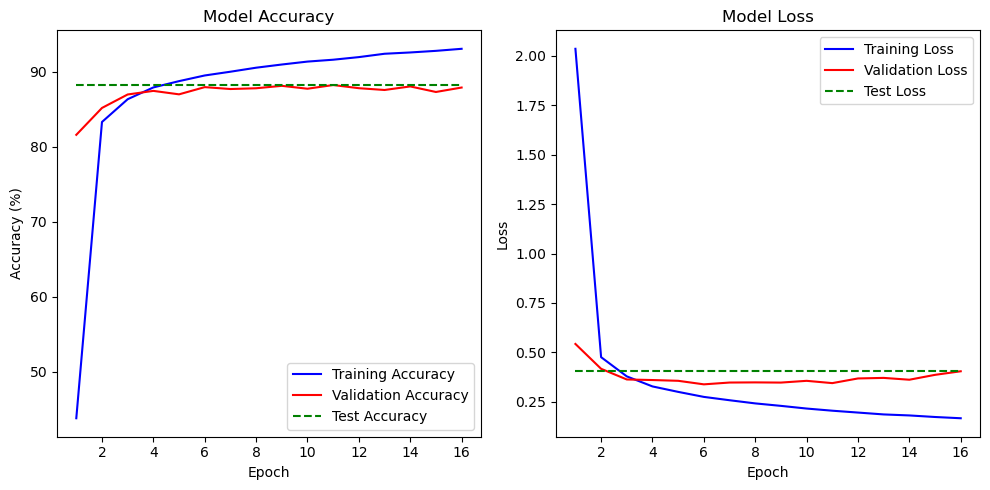

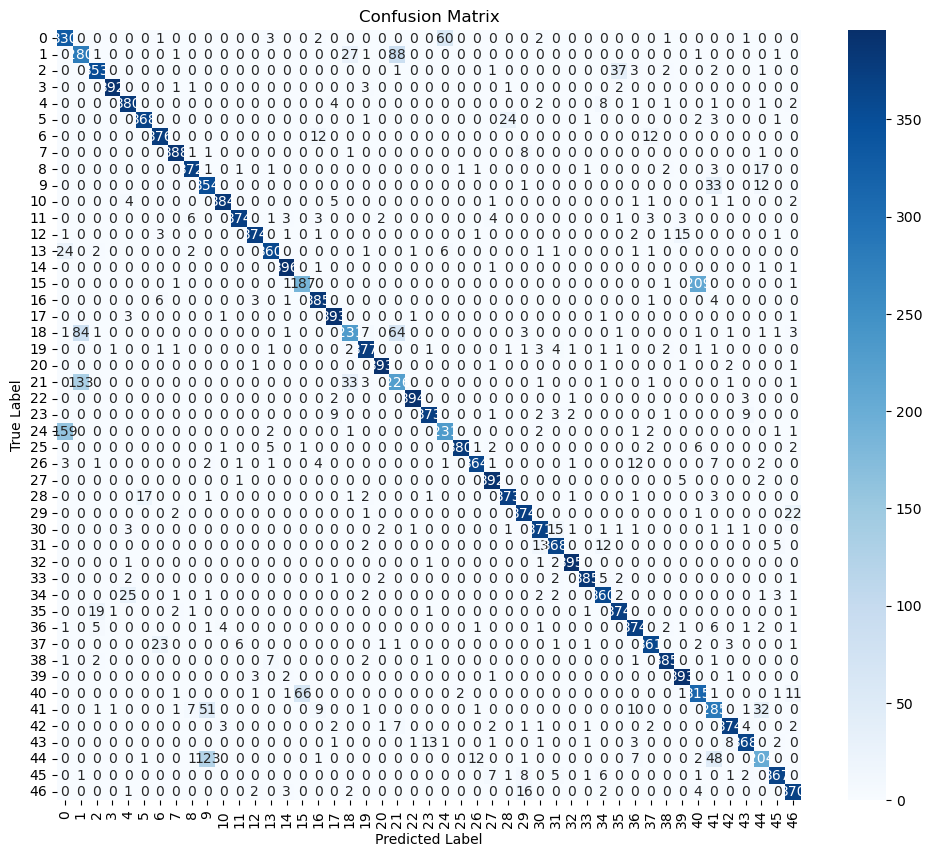

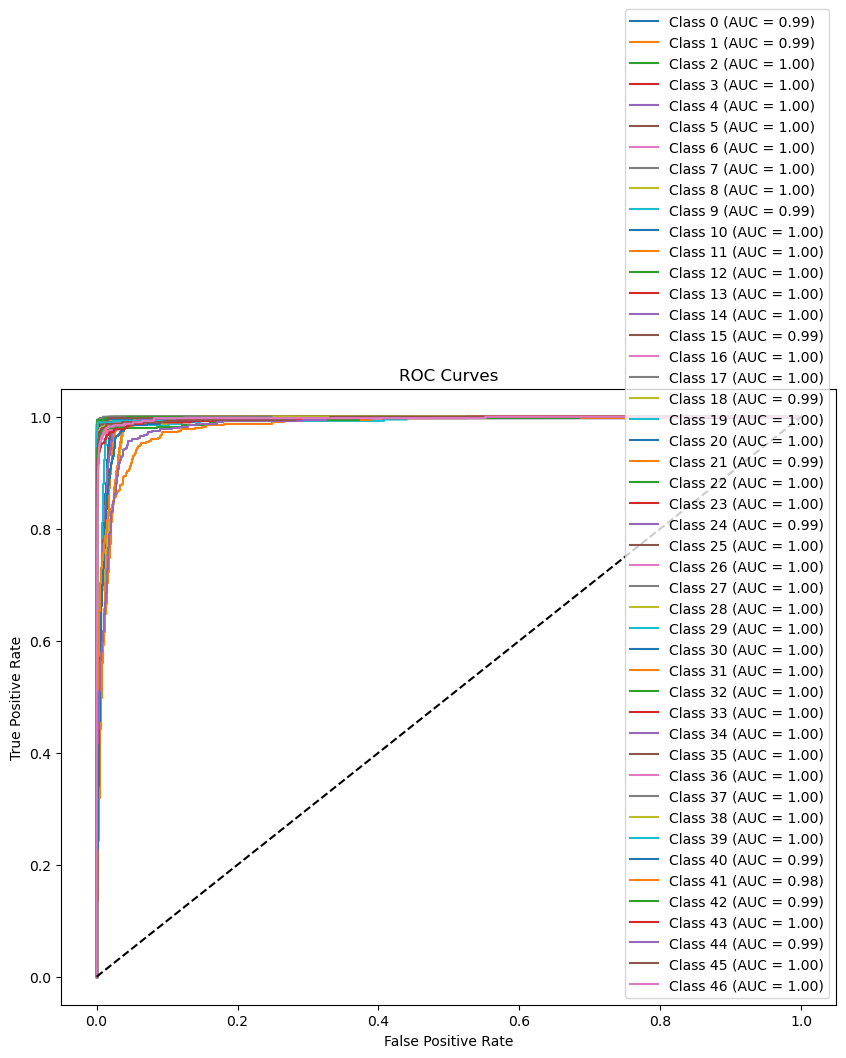

In [32]:
# Step 5: Visualization Functions
def plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies, test_loss, test_acc):
    epochs = range(1, len(train_losses) + 1)
    
    # Plotting accuracies
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_accuracies, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy')
    plt.plot(epochs, [test_acc] * len(epochs), 'g--', label='Test Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    
    # Plotting losses
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_losses, 'b-', label='Training Loss')
    plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
    plt.plot(epochs, [test_loss] * len(epochs), 'g--', label='Test Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Confusion matrix
def plot_confusion_matrix(true_labels, pred_labels, num_classes):
    cm = np.zeros((num_classes, num_classes))
    for t, p in zip(true_labels, pred_labels):
        cm[t][p] += 1
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

#ROC curve
def plot_roc_curve(model, test_loader, num_classes, device):
    model.eval()
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            all_labels.extend(labels.numpy())
            all_probs.extend(probs.cpu().numpy())
    
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)
    
    # Plotting ROC curve for each class
    plt.figure(figsize=(10, 8))
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve((all_labels == i).astype(int), all_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend(loc='lower right')
    plt.show()

def main():
    # For setting the device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Using device: {device}')
    train_loader, val_loader, test_loader = load_data()
    model = VGG13().to(device)
    
    # Setup training parameters
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
    scheduler = StepLR(optimizer, step_size=30, gamma=0.1)
    num_epochs = 100  # Increased from 25 to 100 to allow for early stopping
    
    # Training the model with early stopping
    train_losses, train_accuracies, val_losses, val_accuracies, training_time = train_model(
        model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device
    )

    # Evaluating the model
    test_loss, test_acc, precision, recall, f1, all_preds, all_labels = evaluate_model(
        model, test_loader, criterion, device
    )
    
    # Printing the results
    print(f'\nTest Results:')
    print(f'Test Accuracy: {test_acc:.2f}%')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'Training Time: {training_time:.2f} seconds')
    
    plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies, test_loss, test_acc)
    plot_confusion_matrix(all_labels, all_preds, num_classes=47)
    plot_roc_curve(model, test_loader, num_classes=47, device=device)

if __name__ == '__main__':
    main()
    
    